# Setup

## Installations

In [1]:
! pip install datasets transformers[sentencepiece]

## Libraries

In [2]:
from datasets import load_dataset

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline

import textwrap

# Emotions Dataset

https://huggingface.co/datasets/emotion

## Load

In [3]:
raw_datasets = load_dataset("emotion")

Using custom data configuration default
Reusing dataset emotion (/root/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705)


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [5]:
raw_datasets['test'].features

{'label': ClassLabel(num_classes=6, names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], names_file=None, id=None),
 'text': Value(dtype='string', id=None)}

In [6]:
label_text = {i: label for i, label in enumerate(raw_datasets['test'].features['label'].names)}
label_text

{0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}

## To Pandas

In [7]:
df = {}
for dataset in ['train', 'validation', 'test']:
  df[dataset] = pd.DataFrame.from_records(zip(raw_datasets[dataset]['text'], 
                                              raw_datasets[dataset]['label']), 
                                          columns=['text', 'label'])
  
df['train'].sample(5)

,text,label
9128,i feel about gift cards they re after thoughts...,3
4658,i am feeling really sad,0
10722,i am feeling the positive impact of the new me...,1
13843,im feeling optimistic right now so ill project...,1
10605,i feel so ecstatic and relieved,1


## Some Examples

In [8]:
for _, (text, label) in df['train'].sample(10).iterrows():
  print('\n'.join(textwrap.wrap(text, 100)))
  print(f'-> {label_text[label]}\n')

i am feeling vulnerable worrying that the publishing world doesn t like my stories and won t like
this next one if i write it
-> fear

a scene in a film in which one man repressed another one by concidence
-> anger

im not feeling so tortured around the other one anymore
-> anger

i feel there are a lot of things that i need want must to do but always somehow got distracted got a
call from my crol tl and just told her that couldnt join her as per going to the doc
-> anger

i just like women you also feel this is his truthful straightforwardness flash personality
-> joy

i know is that afterward i feel a hell of a lot more mellow amp relaxed merely by laughing and the
stress of being down in the dumps just melts away
-> joy

i cant help feeling agitated about
-> fear

i stayed for a short while but feeling like he didnt need me anymore and having my own emotional
drainage to work through i decided i needed to go home
-> sadness

i mean my feelings are always sincere i just think part of

## Class Distribution

In [9]:
for name, dataset in df.items():
  print(name)
  print(dataset['label'].map(label_text).value_counts())

train
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: label, dtype: int64
validation
joy         704
sadness     550
anger       275
fear        212
love        178
surprise     81
Name: label, dtype: int64
test
joy         695
sadness     581
anger       275
fear        224
love        159
surprise     66
Name: label, dtype: int64


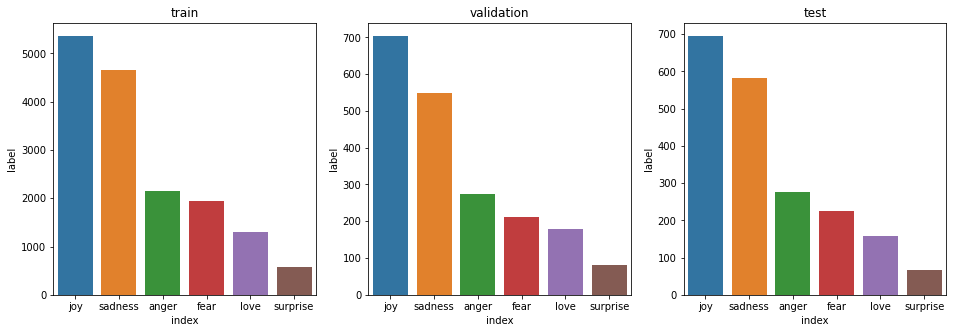

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(16, 5))
for i, (name, dataset) in enumerate(df.items()):
  sns.barplot(
    data=dataset['label'].map(label_text).value_counts().to_frame().reset_index(),
    x="index",
    y="label",
    ax = ax[i]
  )
  ax[i].set_title(name)

# Bag of Words
- Transform text into numeric feature vectors:
  1. Assign a fixed integer id to each word occurring in any document of the training set (for instance by building a dictionary from words to integer indices).

  2. For each document #i, count the number of occurrences of each word w and store it in X[i, j] as the value of feature #j where j is the index of word w in the dictionary.

- If the vocabulary is large and there are many documenst, then X matrix will barely fit into the RAM.

- But since most entries in X tend to be zero, we can use Python's sparse matrix representation!

## Occurence Count

In [11]:
count_vect = CountVectorizer()

X_train_bow = count_vect.fit_transform(df['train']['text'])
X_valid_bow = count_vect.transform(df['validation']['text'])
X_test_bow = count_vect.transform(df['test']['text'])

print(X_train_bow.shape)
print(X_valid_bow.shape)
print(X_test_bow.shape)

(16000, 15186)
(2000, 15186)
(2000, 15186)


In [12]:
idx = 0
print(df['train']['text'][idx], '\n', X_train_bow[idx])

i didnt feel humiliated 
   (0, 3615)	1
  (0, 4924)	1
  (0, 6429)	1


In [13]:
pd.DataFrame.from_dict(count_vect.vocabulary_, orient='index', columns=['id']).sample(10)

,id
quilting,10611
recipes,10796
colours,2485
kendo,7320
manipulated,8087
instinct,6847
lard,7509
companion,2555
trips,13866
reaffirmed,10748


In [14]:
count_vect.vocabulary_.get(u'happy')

5988

## N-Grams
for a little more context

In [15]:
help(CountVectorizer)

Help on class CountVectorizer in module sklearn.feature_extraction.text:

class CountVectorizer(_VectorizerMixin, sklearn.base.BaseEstimator)
 |  CountVectorizer(input='content', encoding='utf-8', decode_error='strict', strip_accents=None, lowercase=True, preprocessor=None, tokenizer=None, stop_words=None, token_pattern='(?u)\\b\\w\\w+\\b', ngram_range=(1, 1), analyzer='word', max_df=1.0, min_df=1, max_features=None, vocabulary=None, binary=False, dtype=<class 'numpy.int64'>)
 |  
 |  Convert a collection of text documents to a matrix of token counts
 |  
 |  This implementation produces a sparse representation of the counts using
 |  scipy.sparse.csr_matrix.
 |  
 |  If you do not provide an a-priori dictionary and you do not use an analyzer
 |  that does some kind of feature selection then the number of features will
 |  be equal to the vocabulary size found by analyzing the data.
 |  
 |  Read more in the :ref:`User Guide <text_feature_extraction>`.
 |  
 |  Parameters
 |  ---------

In [16]:
count_vect = CountVectorizer(ngram_range=(2, 2))

X_train_bow = count_vect.fit_transform(df['train']['text'])
X_valid_bow = count_vect.transform(df['validation']['text'])
X_test_bow = count_vect.transform(df['test']['text'])

print(X_train_bow.shape)
print(X_valid_bow.shape)
print(X_test_bow.shape)

pd.DataFrame.from_dict(count_vect.vocabulary_, orient='index', columns=['id']).sample(10)

(16000, 109796)
(2000, 109796)
(2000, 109796)


,id
big kid,13475
stood right,84909
pleasant person,71121
and regard,6020
sleepy lot,81088
dull selectively,25854
havent heard,40090
at helping,9500
wonderful you,107506
overly dramatic,68616


❓ Do you see a problem with occurrence counts or n-grams?

## tf-idf

- With occurences, longer documents will have higher average count values than shorter documents, even though they might talk about the same topics, reflect the same feeling. We correct this:

  1. So let's divide the number of occurrences of each word in a document by the total number of words in the document: these new features are called _tf_ for Term Frequencies.

  2. Let's also downscale weights for words that occur in many documents in the corpus and are therefore less informative than those that occur only in a smaller portion of the corpus.

- This encoding is called _tf–idf_ for “Term Frequency times Inverse Document Frequency”.

In [17]:
count_vect = CountVectorizer()

X_train_bow = count_vect.fit_transform(df['train']['text'])
X_valid_bow = count_vect.transform(df['validation']['text'])
X_test_bow = count_vect.transform(df['test']['text'])

tfidf_transformer = TfidfTransformer()

X_train_tfidf = tfidf_transformer.fit_transform(X_train_bow)
X_valid_tfidf = tfidf_transformer.transform(X_valid_bow)
X_test_tfidf = tfidf_transformer.transform(X_test_bow)

print(X_train_tfidf.shape)
print(X_valid_tfidf.shape)
print(X_test_tfidf.shape)

(16000, 15186)
(2000, 15186)
(2000, 15186)


In [18]:
idx = 0
print(df['train']['text'][idx], '\n', X_train_tfidf[idx])

i didnt feel humiliated 
   (0, 6429)	0.7867657412767967
  (0, 4924)	0.16379156905484632
  (0, 3615)	0.5951235084078971


# Classification

## [Naive Baies](https://scikit-learn.org/stable/modules/naive_bayes.html#naive-bayes)

In [19]:
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB()
model.fit(X_train_tfidf, df['train']['label'])

predictions = model.predict(X_test_tfidf)

acc = accuracy_score(df['test']['label'], predictions)
print(f'Accuracy: {acc*100:.2f}%')

Accuracy: 64.85%


## [SVM](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)

In [20]:
model = SGDClassifier()
model.fit(X_train_tfidf, df['train']['label'])

predictions = model.predict(X_test_tfidf)

acc = accuracy_score(df['test']['label'], predictions)
print(f'Accuracy: {acc*100:.2f}%')

Accuracy: 89.35%


# Confusion Matrix

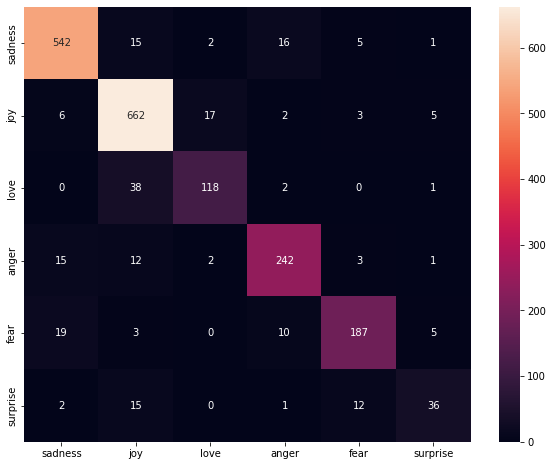

In [21]:
fig, ax = plt.subplots(figsize=(10, 8))

cm = confusion_matrix(df['test']['label'].values, predictions)
sns.heatmap(cm, annot=True, fmt='g', ax=ax)

ticks = np.arange(0.5,6.5,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)

ax.set_xticklabels(label_text.values())
ax.set_yticklabels(label_text.values())

plt.show()

# Pipelines

In [22]:
model = Pipeline([('vect', CountVectorizer()),
                  ('tfidf', TfidfTransformer()),
                  ('clf', SGDClassifier())])

model.fit(df['train']['text'], df['train']['label'])

predictions = model.predict(df['test']['text'])

acc = accuracy_score(df['test']['label'], predictions)
print(f'Accuracy: {acc*100:.2f}%')

Accuracy: 89.55%


❓ Can you come up with a tweet that confuses the model?

In [23]:
label_text[model.predict(['i am happy'])[0]]

'joy'